In [ ]:
'''
tr_dataset = TimeSeriesDataSet(
    split_train,  # 전체 시계열 데이터
    time_idx='time_idx', # 시계열 순서를 나타내는 인덱스(정수형)
    target='전력소비량(kWh)', # 예측하고자 하는 값
    group_ids= ['건물번호'] ,  # 시계열을 구분하는 그룹 (건물 번호, ID 등) -> 같은 건물이어도 시간에 따라 다른 값을 보이기 때문에 동일한 건물을 시간 순서로 나눔
    
    max_prediction_length = 72,  # 예측하고 싶은 미래 구간 길이, 72 -> 24*3= 3일 분량 예측
    max_encoder_length = 168 , # 입력 시계열의 길이 (과거 히스토리 길이) -> 1주일 간 사용

    static_categoricals = ["건물유형"], # 시계열별 고정 범주형 변수 (ex 매장 유형)
    static_reals = ['연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'] ,# 시계열별 고정 연속형 변수  (ex 매장 크기)

    time_varying_known_categoricals = ['month', 'day', 'time'], # 미래에도 알 수 있는 범주형 변수(달, 요일, 주말 변수)
    time_varying_known_reals = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '불쾌지수'],  # 미래에도 알 수 있는 연속형 변수 
    time_varying_unknown_reals = ['전력소비량(kWh)'], # 미래에 알 수 없는 연속형 변수 (판매량, 전력 사용량 등등 -> 실제 예측 대상)

    # target_normalizer = GroupNormalizerg(groups = ['~~'])) , #  종속 변수의 정규화를 그룹 별로 수행(평균 0, 분산 1)

    add_relative_time_idx = True, # 모델 입력에 '현재 인덱스가 예측 구간에서 몇 번째인가'를 포함
    # add_target_scales = True,  # 정규화할 때 쓴 평균과 표준편차 값을 모델 입력에도 포함 -> 예측 복원에 도움  ??????????????
    add_encoder_length = True, # 인코더에 입력한 실제 시계열 길이를 모델에 알려줌
    
)
'''

In [ ]:
'''
    ESS저장용량 -> Energy Storage System의 약어료, 에너지 저장 장치가 한 번에 저장할 수 있는 총 전기 에너지 양을 의미
    이 값이 클수록 더 많은 전력을 저장하여 필요 시 사용 가능
    물탱크와 같은 역할
    
    PCS용량 -> Power Conversion System의 약어로, ESS에 저장된 전기를 실제로 얼마나 빠르게 충전하거나 공급할 수 있는지를 나타내는 값
    수도관의 굵기로 비유
'''

In [377]:
import holidays
import itertools
import optuna

import pandas as pd 
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting import GroupNormalizer # 개별 그룹 단위 평균 0, 분산 1로 정규화 
from pytorch_forecasting.metrics import SMAPE


from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import copy

from tqdm import tqdm
import random

from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer

from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateFinder, LearningRateMonitor, EarlyStopping


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [379]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # PyTorch GPU 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN의 결정론적 연산 보장
    torch.backends.cudnn.benchmark = False  # CuDNN의 비결정적 알고리즘 비활성화
    random.seed(seed)
    np.random.seed(seed)

In [671]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")
bd_info = pd.read_csv("building_info.csv")
sub_sample = pd.read_csv("sample_submission.csv")

train['time_idx'] = train.groupby('건물번호').cumcount()
test['time_idx'] = test.groupby('건물번호').cumcount() + len(train[train['건물번호'] == 1])

def no_value_change(df, col):
    df[col] = df[col].replace('-', 0).astype(float)

no_value_change(bd_info, '태양광용량(kW)')
no_value_change(bd_info, 'ESS저장용량(kWh)')
no_value_change(bd_info, 'PCS용량(kW)')

In [672]:
new_train = []
new_valid = []
new_test = []

for building_num in train['건물번호'].unique():
    train_N = len(train[train['건물번호'] == building_num])

    temp_train = train[train['건물번호'] == building_num].iloc[:int(train_N)-338]
    temp_valid = train[train['건물번호'] == building_num].iloc[int(train_N)-338 : int(train_N)-169]
    temp_test =  train[train['건물번호'] == building_num].iloc[int(train_N)-169 : ]

    new_train.append(temp_train)
    new_valid.append(temp_valid)
    new_test.append(temp_test)

train = pd.concat(new_train)
valid = pd.concat(new_valid).reset_index(drop=True)
test = pd.concat(new_test).reset_index(drop=True)

In [673]:
target = []

for building_num in test['건물번호'].unique():
    test_N = len(test[test['건물번호'] == building_num])
    for_test_target = test[test['건물번호'] == building_num].iloc[1:]
    target.append(for_test_target)

test_target = pd.concat(target).reset_index(drop=True)['전력소비량(kWh)']

In [676]:
peak_time = [f'{i}' for i in range(7, 21)]

def dataframe_summary(df):
    print(f"데이터 shape : {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=["Data_type"])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'feature'})
    summary['null_info'] = df.isnull().sum().values
    summary['unique_info'] = df.nunique().values
    summary['first_data'] = df.loc[0].values
    summary['second_data'] = df.loc[1].values
    summary['third_data'] = df.loc[2].values
    
    return summary

def date_transform(df):
    korea_holidays = holidays.KR(years = [2024])
    
    df['일시'] = pd.to_datetime(df['일시'], format = '%Y%m%d %H')

    # df['month'] = df['일시'].dt.month
    # df['day'] = df['일시'].dt.day
    # df['time'] = df['일시'].dt.hour


    df['date_only'] = df['일시'].dt.date # 시간을 제외한 날짜 형식만 저장
    df['is_holiday'] = df['date_only'].isin(korea_holidays).astype(int) # 공휴일 정보 매핑 
    
    df['month'] = (df['일시'].dt.month).astype(str).astype('category')
    df['day'] = (df['일시'].dt.day).astype(str).astype('category')
    df['time'] = (df['일시'].dt.hour).astype(str).astype('category')
    
    df['weekday'] = df['일시'].dt.weekday # 주중, 주말 구분 위해 생성
    
    df['is_offday'] = ((df['is_holiday'] == 1) | (df['weekday'] >= 5)).map({False : '0', True : '1'}).astype('category') # 주말이면서, 공휴일인 날 구분하기 위해 생성
    df['peak_time'] = ((df['is_holiday'] == 0) & (df['time'].isin(peak_time)) ).map({False : '0', True : '1'}).astype('category')
    
    df.drop(['일시', 'weekday', 'is_holiday','date_only', 'num_date_time'], axis =1, inplace=True)
    # df.drop('num_date_time', axis =1, inplace=True)
    
date_transform(train)
date_transform(valid)
date_transform(test)

In [675]:
for building_num in train['건물번호'].unique():
    per_building_value = dict(train[train['건물번호'] == building_num].groupby('time')['일조(hr)'].mean())
    for i in range(len(test[test['건물번호'] == building_num])):
        test[test['건물번호'] == building_num][i] = per_building_value[test['time'][i]]

for building_num in train['건물번호'].unique():
    per_building_value = dict(train[train['건물번호'] == building_num].groupby('time')['일사(MJ/m2)'].mean())
    for i in range(len(test[test['건물번호'] == building_num])):
        test[test['건물번호'] == building_num][i] = per_building_value[test['time'][i]]

In [516]:
# test['cycle_time'] = np.round(((np.sin(2 * np.pi * test['time'] / 24)) + 1) / 2, 4)
# test['일조(hr)'] = 0 + (1-0)* test['cycle_time']
# test['일사(MJ/m2)'] = 0 + (3.95-0)* test['cycle_time']
# # train.drop(['month','day','time'], axis=1,inplace=True)

In [517]:
# test['일조(hr)'] = np.round(np.where(test['time'].isin(peak_time), test['일조(hr)'], 0.0),1)
# test['일사(MJ/m2)'] =  np.round(np.where(test['time'].isin(peak_time), test['일사(MJ/m2)'], 0.00), 2) 

In [519]:
test.drop('cycle_time',axis=1, inplace=True)

## 일조, 일사 생성

In [677]:
# 불쾌 지수 파생변수 생성

train['불쾌지수'] = (train['기온(°C)'] - 0.55 * (1-0.01 * train['습도(%)']) * (train['기온(°C)'] - 14.5)).astype('int')
valid['불쾌지수'] = (valid['기온(°C)'] - 0.55 * (1-0.01 * valid['습도(%)']) * (valid['기온(°C)'] - 14.5)).astype('int')
test['불쾌지수'] = (test['기온(°C)'] - 0.55 * (1-0.01 * test['습도(%)']) * (test['기온(°C)'] - 14.5)).astype('int')

"""
불쾌지수(DI)
“Discomfort Index Calculator” –> DI = T − 0.55·(1 − 0.01·RH)·(T − 14.5)

DI < 21 -> 불쾌감 거의 없음,
21 =< DI < 24 -> 약간의 불쾌감,
24 =< DI < 26 -> 조금 더 강한 불쾌감,
26 =< DI -> 불쾌감 강함

"""

bd_info['cooling_ratio'] = bd_info['냉방면적(m2)'] / bd_info['연면적(m2)']

In [681]:
def standard_scaler(df, col):
    s_scaler = StandardScaler()
    s_transformer = s_scaler.fit(df[[col]])

    return s_transformer.transform(df[[col]])


def minmax_scaler(df, col):
    mn_scaler = MinMaxScaler()
    mn_transformer = mn_scaler.fit(df[[col]])

    return mn_transformer.transform(df[[col]])

def robust_scaler(df, col):
    r_scaler = RobustScaler()
    r_transformer = r_scaler.fit(df[[col]])

    return r_transformer.transform(df[[col]])

In [682]:
bd_info[['연면적(m2)']] = robust_scaler(bd_info, '연면적(m2)')
bd_info[['냉방면적(m2)']] = robust_scaler(bd_info, '냉방면적(m2)')

bd_info[['태양광용량(kW)']] = minmax_scaler(bd_info, '태양광용량(kW)')
bd_info[['ESS저장용량(kWh)']] = minmax_scaler(bd_info, 'ESS저장용량(kWh)')
bd_info[['PCS용량(kW)']] = minmax_scaler(bd_info, 'PCS용량(kW)')

In [683]:
merge_train = pd.merge(train, bd_info, on = '건물번호', how = 'inner')
merge_valid = pd.merge(valid, bd_info, on = '건물번호', how = 'inner')
merge_test = pd.merge(test, bd_info, on = '건물번호', how = 'inner')

In [182]:
df = train.groupby(['month','day','time'])['전력소비량(kWh)'].mean()
df = df.reset_index()

june_df = df[df['month'] == 6]
july_df = df[df['month'] == 7]
august_df = df[df['month'] == 8]

june = june_df.groupby('time').mean()
july = july_df.groupby('time').mean()
august = august_df.groupby('time').mean()

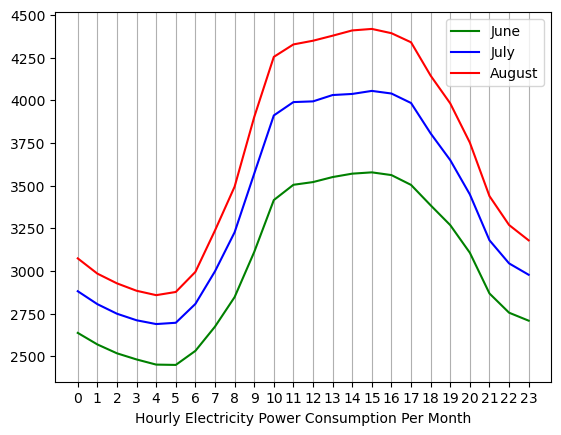

In [184]:
plt.plot(june['전력소비량(kWh)'], color = 'g', label = 'June')
plt.plot(july['전력소비량(kWh)'], color = 'b' , label = 'July')
plt.plot(august['전력소비량(kWh)'], color = 'r' , label = 'August')
plt.xticks(ticks=range(0, 24))
plt.xlabel('Hourly Electricity Power Consumption Per Month')
plt.grid(axis = 'x')

plt.legend()

In [689]:
color_list = [  
    'orange', 'pink', 'purple', 'brown', 'dodgerblue', 'gold', 'lime', 'olive', 'navy', 'crimson', 'b', 'springgreen','violet', 'tomato', 'limegreen'
]

Text(0, 0.5, 'Sunshine duration')

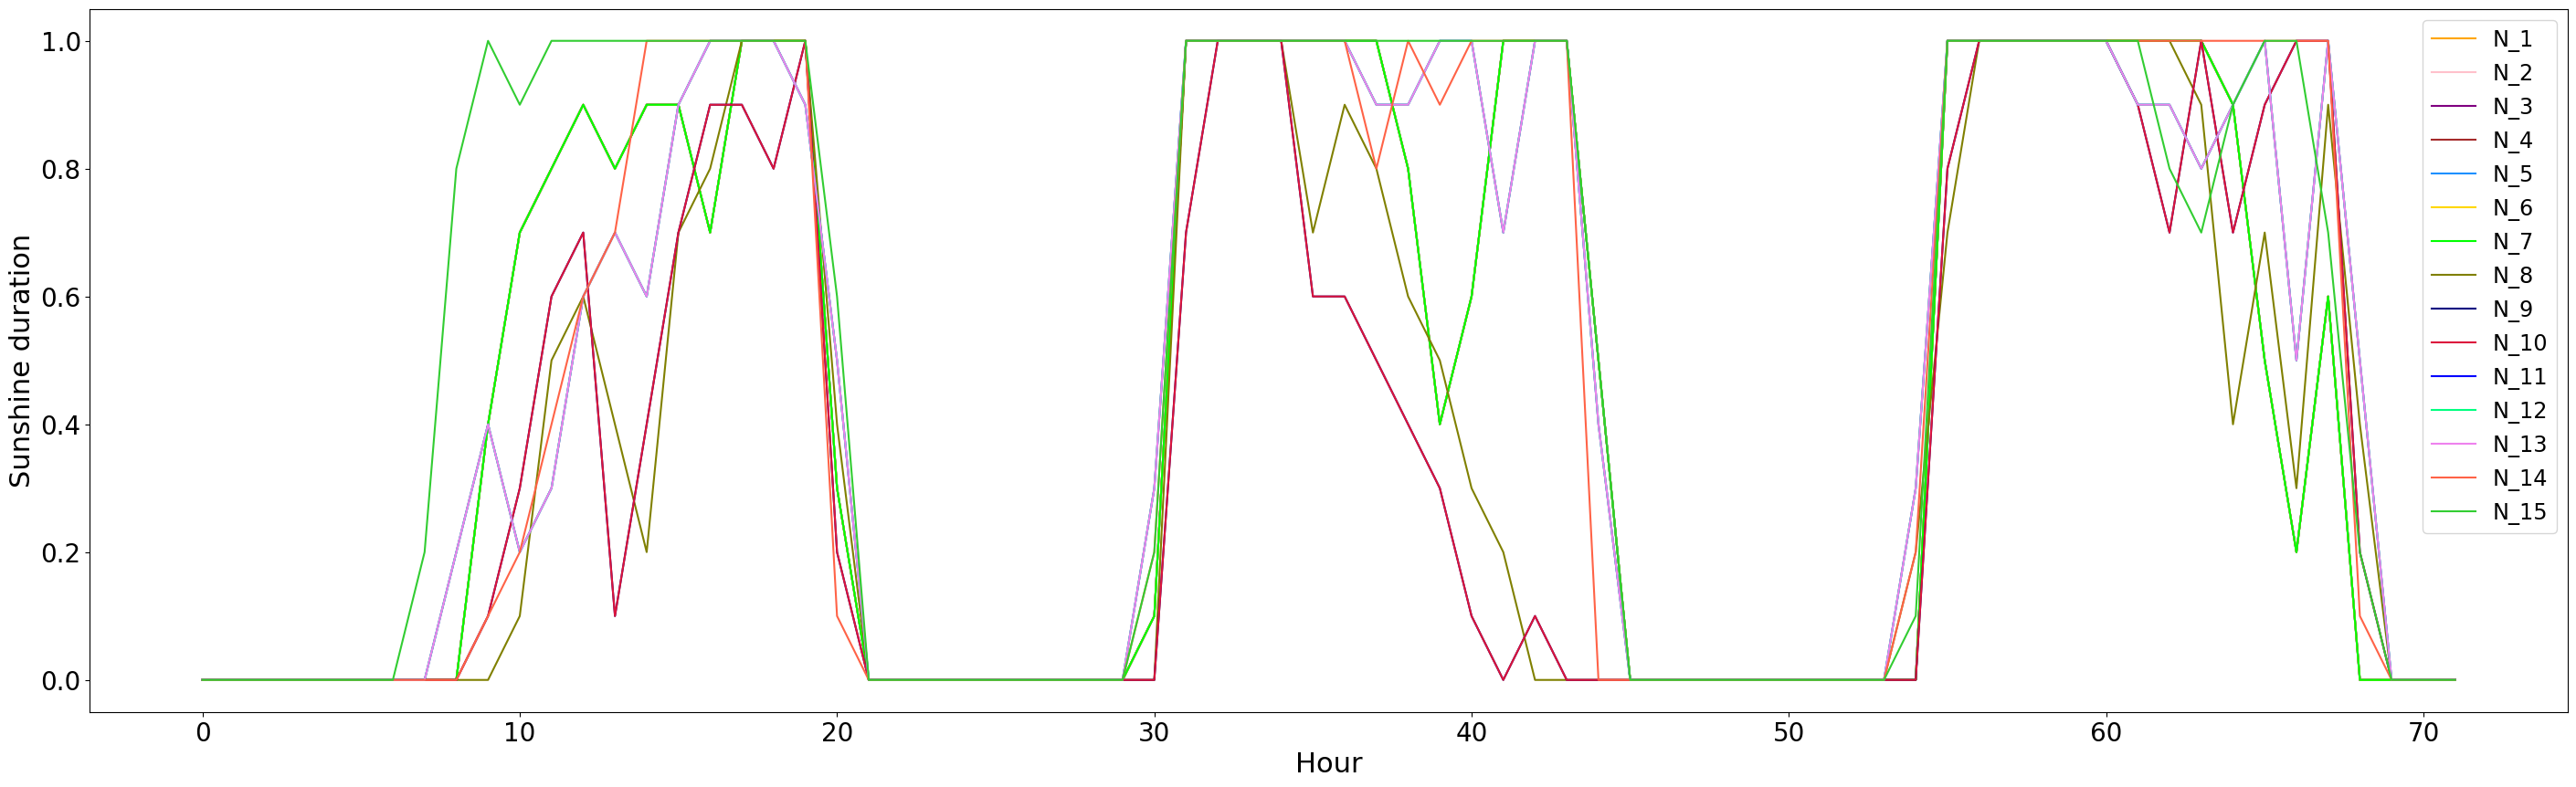

In [690]:

plt.subplots(figsize = (35,10))

for i, color in enumerate(color_list):
    plt.plot( train[train['건물번호'] == i+1]['일조(hr)'][:72].reset_index(drop=True), color= color, label = f'N_{i+1}')
    
plt.legend(fontsize = 'xx-large')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Hour', fontsize= 22)
plt.ylabel('Sunshine duration', fontsize= 22)

Text(0, 0.5, 'Sunshine duration')

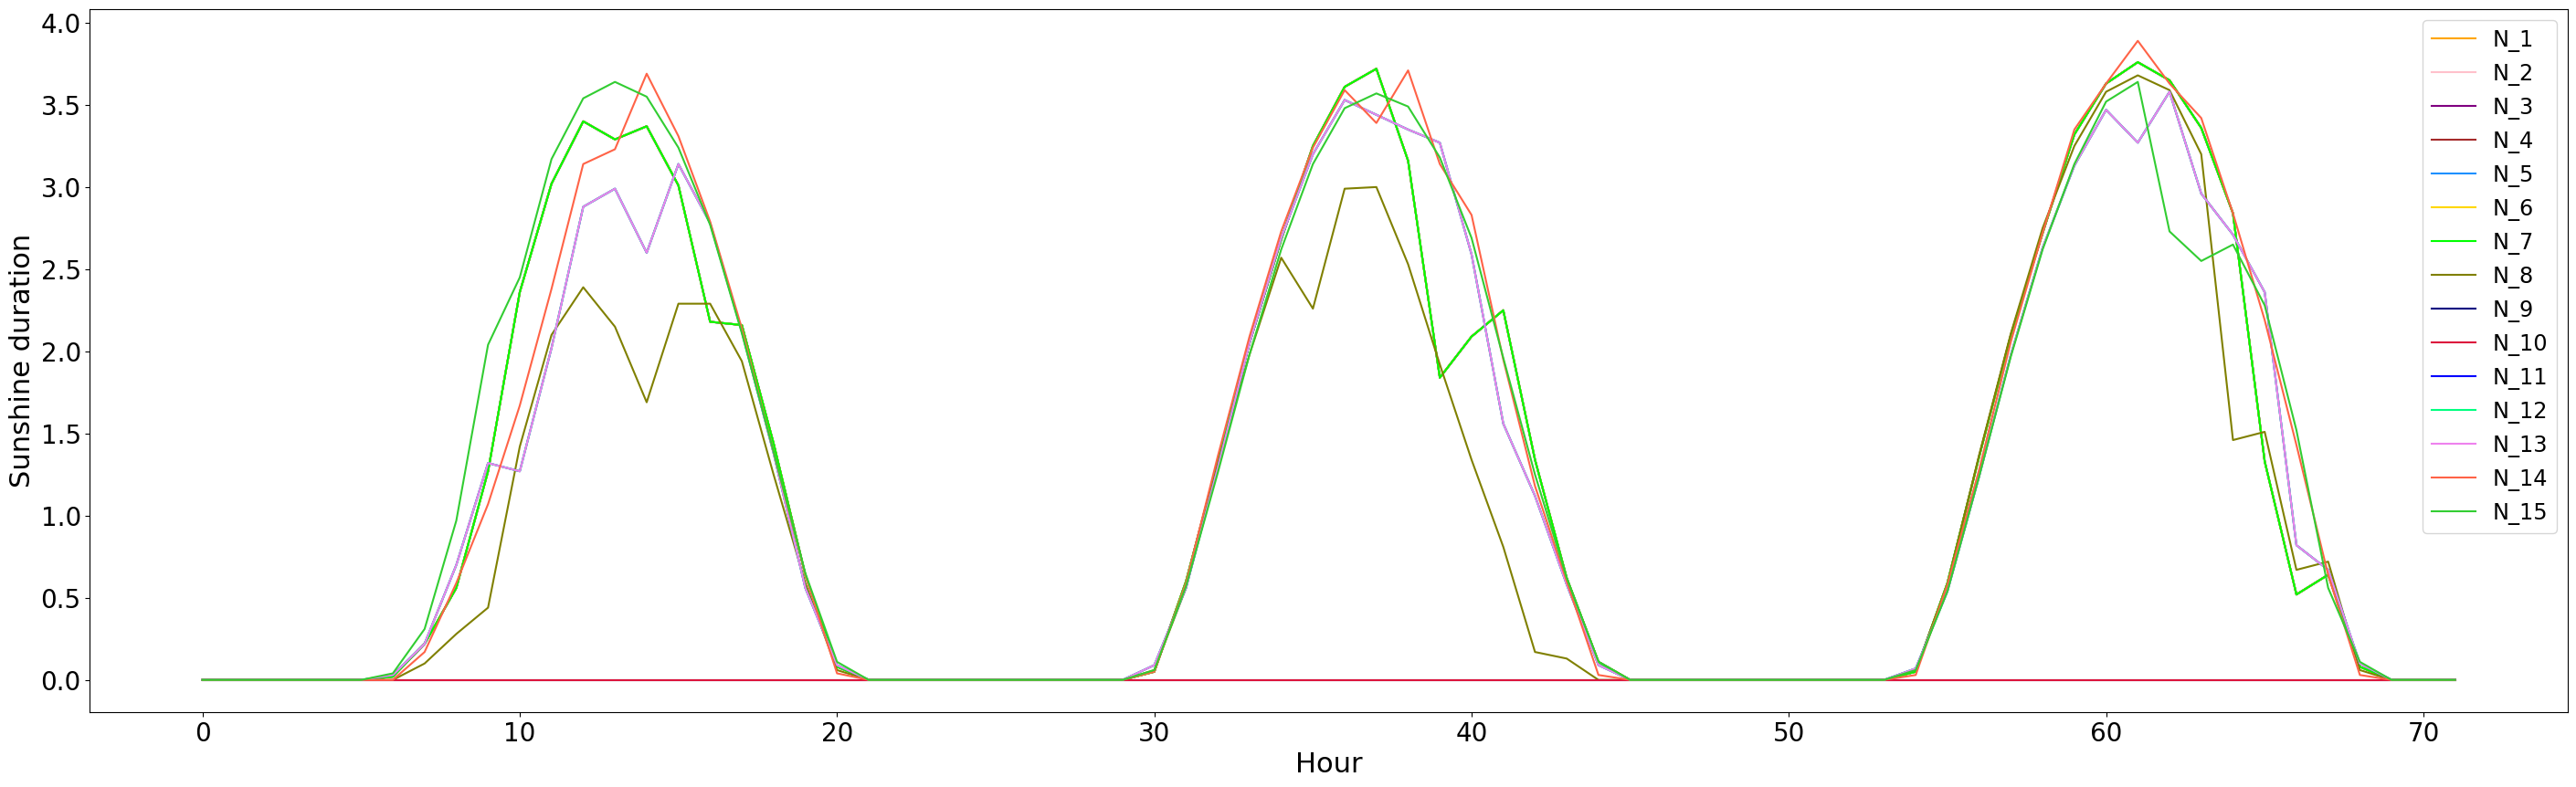

In [691]:
plt.subplots(figsize = (35,10))

for i, color in enumerate(color_list):
    plt.plot( train[train['건물번호'] == i+1]['일사(MJ/m2)'][:72].reset_index(drop=True), color= color, label = f'N_{i+1}')
    
plt.legend(fontsize = 'xx-large')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Hour', fontsize= 22)
plt.ylabel('Sunshine duration', fontsize= 22)

In [685]:
max_encoder_length = 24 * 7 * 2 
max_prediction_length = 24 * 7

# categorical_encoders= {'month': NaNLabelEncoder(add_nan=True),
#                        'day': NaNLabelEncoder(add_nan=True)}

tr_dataset = TimeSeriesDataSet(
    merge_train,
    # split_train,  # 전체 시계열 데이터
    time_idx = "time_idx", # 시계열 순서를 나타내는 인덱스(정수형)
    target = "전력소비량(kWh)", # 예측하고자 하는 값
    group_ids = ['건물번호'] ,  # 시계열을 구분하는 그룹 (건물 번호, ID 등) -> 같은 건물이어도 시간에 따라 다른 값을 보이기 때문에 동일한 건물을 시간 순서로 나눔

    # categorical_encoders = categorical_encoders,
    
    max_encoder_length = max_encoder_length , # 입력 시계열의 길이 (과거 히스토리 길이) -> 1주일 간 사용
    max_prediction_length = max_prediction_length,  # 예측하고 싶은 미래 구간 길이, 72 -> 24*3= 3일 분량 예측
    min_encoder_length = 1,
    min_prediction_length = 1, 
    
    static_categoricals = ['건물유형'], # 시계열별 고정 범주형 변수 (ex 매장 유형)
    # static_categoricals = ['건물유형', 'is_solar', 'is_ess', 'is_pcs'], # 시계열별 고정 범주형 변수 (ex 매장 유형)
    static_reals = ['연면적(m2)', '냉방면적(m2)', 'cooling_ratio', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'],
     # static_reals = ['연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'],
    # static_reals = ['연면적(m2)', '냉방면적(|m2)'],
    # static_reals = ['연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'],
                    # 시계열별 고정 연속형 변수  (ex 매장 크기) 'cooling_ratio'

    time_varying_known_categoricals = ['month', 'day', 'time', 'is_offday', 'peak_time'], # 미래에도 알 수 있는 범주형 변수(달, 요일, 주말 변수)
    # time_varying_known_categoricals = ['month', 'day', 'time'], # 미래에도 알 수 있는 범주형 변수(달, 요일, 주말 변수)
    # time_varying_known_categoricals = ['time', 'is_offday', 'peak_time'], # 미래에도 알 수 있는 범주형 변수(달, 요일, 주말 변수)
    
    time_varying_known_reals = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '불쾌지수', '일조(hr)', '일사(MJ/m2)'],  # 미래에도 알 수 있는 연속형 변수   '불쾌지수'
    # time_varying_known_reals = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '불쾌지수'],
    time_varying_unknown_reals = ['전력소비량(kWh)'], # 미래에 알 수 없는 연속형 변수 (판매량, 전력 사용량 등등 -> 실제 예측 대상)

    target_normalizer = GroupNormalizer(groups = ['건물번호'], transformation='softplus'), #  종속 변수의 정규화를 그룹 별로 수행(평균 0, 분산 1)
    scalers = {
        '기온(°C)' : StandardScaler(),
        # '강수량(mm)' : StandardScaler(),
        # '풍속(m/s)' : StandardScaler(),
        '습도(%)' : StandardScaler(),
        '불쾌지수' : StandardScaler() 
    },
    
    add_relative_time_idx = True,
    add_encoder_length = True
)

In [686]:
val_dataset = TimeSeriesDataSet.from_dataset(
    tr_dataset,
    merge_valid,
    # split_valid,
    predict = True,
    stop_randomization = True
    
)

merge_test['전력소비량(kWh)'] = 0.0 # 값이 없어도 생성을 해야 predict = True 옵션이 사용됨

test_dataset = TimeSeriesDataSet.from_dataset(
    tr_dataset,
    merge_test,
    # last_test.reset_index().drop('index', axis = 1),
    predict = True,
    stop_randomization = True
    
)

tr_dataloader = tr_dataset.to_dataloader(train=True, batch_size= 128, shuffle = True) #  shuffle 옵셔은 샘플 간 순서만 섞는 거
val_dataloader = val_dataset.to_dataloader(train=False, batch_size= 128, shuffle = False)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size= 128, shuffle = False)

In [667]:
class early_stop:
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, loss):
        if loss < self.best_loss - self.delta:
            self.best_loss = loss
            self.counter = 0 
        else:
            self.counter += 1

        if self.counter >= self.patience:
            return True
        return False  # False를 반환하면 학습 중단

In [668]:
class TFT(nn.Module):
    def __init__(self, lr, dropout, lstm_hidden, mha, hidden_c_size):
        super(TFT, self).__init__()

        self.tft_model = TemporalFusionTransformer.from_dataset(
            tr_dataset, # 모델이 사용할 피저 구조, 인코더-디코더 길이 등을 파악, TomeSeiresDataSet 객체
            # learning_rate = lr, # 모델 학습률
            hidden_size = lstm_hidden, # LSTM의 인코더-디코더 각 레이어의 은닉 차원 수, 클수록 과적합 가능성, 연산 비용 커짐
            attention_head_size = mha , #멀티헤드 셀픙 어텐션 헤드 개수
            dropout = dropout,
            # loss = SMAPE(),
            # logging_metrics = [SMAPE()],
            hidden_continuous_size = hidden_c_size,  # 연속형 피처 처리용 작은 은닉층 크기, 모델 내부에서 GRN이 각 연속형 피처를 임베딩하는 차원
            output_size = 1, # 모델 최종 출력 차원
        ).to(device)

        self.optimizer = torch.optim.AdamW(
            params = self.tft_model.parameters(), 
            lr = lr,
            # weight_decay= 0.05
        )
        
        # self.criterion = nn.MSELoss()
        # self.criterion = nn.L1Loss()
        # self.criterion = nn.HuberLoss(delta=delta)
        self.early_stop = early_stop(5, 0.0001)

    def smape(self, preds, trues, eps = 1e-8):
        """
        Symmetric Mean Absolute Percentage Error (SMAPE) Loss
        """
        numerator = torch.abs(trues - preds)
        denominator = torch.abs(trues) + torch.abs(preds) + eps
        smape = 2.0 *numerator / denominator

        return torch.mean(smape)


    def train_model(self):
        best_loss_ever = float('inf')
        best_weight = None
        num_epochs = 50
        for epoch in range(num_epochs):
            self.tft_model.train()
            for batch in tqdm(tr_dataloader, total = len(tr_dataloader)):
                inputs, (targets, _) = batch
                
                inputs = {k : v.to(device) for k, v in inputs.items()}
                targets = targets.to(device)

            
                self.optimizer.zero_grad()
                output = self.tft_model(inputs)  # model.predict() 메서드는 데이터로더를 입력으로 받
                y_preds = (output.prediction).squeeze(-1)


                # loss = self.criterion(y_preds, targets)

                loss = self.smape(y_preds, targets)
                
                loss.backward()
                self.optimizer.step()
                clip_grad_norm_(self.tft_model.parameters(), max_norm = 10)

            val_loss = self.validation()

            if val_loss < best_loss_ever:
                best_loss_ever = val_loss
                best_weight = copy.deepcopy(self.tft_model.state_dict())
                print(best_loss_ever)
                print("best Loss")
                print("===================================")

            if self.early_stop(val_loss):
                print(f"Early Stopping at epoch : {epoch + 1}")
                break

        if best_weight is not None:
            self.tft_model.load_state_dict(best_weight)
        else:
            print("Not Saved Params")

        return best_loss_ever

    def validation(self):
        self.tft_model.eval()
        val_total_loss = 0.0
        with torch.no_grad():
            for val_batch in val_dataloader:
                val_inputs, (val_targets, _) = val_batch
                val_inputs = {k:v.to(device) for k, v in val_inputs.items()}
                val_targets = val_targets.to(device)

                val_output = self.tft_model(val_inputs)
                val_preds = (val_output.prediction).squeeze(-1)

                # val_total_loss += self.criterion(val_preds, val_targets).item()
                val_total_loss += self.smape(val_preds, val_targets).item()
               

        return val_total_loss / len(val_dataloader)
        # return val_total_loss 

    def test(self):
        self.tft_model.eval()
        all_preds = []
        with torch.no_grad():
            # test_preds = self.tft_model.predict(test_dataloader)
            for test_batch in test_dataloader:
                test_inputs, (test_targets, _) = test_batch
                test_inputs = {k:v.to(device) for k, v in test_inputs.items()}
                test_targets = test_targets.to(device)

                test_output = self.tft_model(test_inputs)
                test_preds = (test_output.prediction).squeeze(-1)
   
                all_preds.append(test_preds)
            
        return torch.cat(all_preds, dim = 0)
        # return test_preds

In [370]:
import gc
gc.collect()
del tft_model
torch.cuda.empty_cache()

In [243]:
set_seed(42)
tft_model = TFT(4e-3, 0, 80, 1, 32)
tft_model.train_model()
result = tft_model.test()

100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [10:11<00:00,  2.82it/s]


0.1356412172317505
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [10:08<00:00,  2.83it/s]


0.1344819813966751
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [10:08<00:00,  2.83it/s]


0.13008283078670502
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [10:08<00:00,  2.83it/s]


0.12518054246902466
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [10:06<00:00,  2.84it/s]


0.11652925610542297
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [10:06<00:00,  2.84it/s]


Early Stopping at epoch : 10


In [309]:
def smape(preds, trues, eps = 1e-8):
    """
    Symmetric Mean Absolute Percentage Error (SMAPE) Loss
    """
    # numerator = torch.abs(trues - preds)
    # denominator = torch.abs(trues) + torch.abs(preds) + eps
    # smape = 2.0 *numerator / denominator
        
    # return torch.mean(smape)

    numerator = np.abs(trues - preds)
    denominator = np.abs(trues) + np.abs(preds) + eps
    smape = 2.0 *numerator / denominator

    return np.mean(smape)

smape(sub_sample['answer'], test_target)

# CASE 02 테스트 셋 결과

0.12967813537413725

In [331]:
set_seed(42)
tft_model = TFT(4e-3, 0, 80, 1, 32)
tft_model.train_model()
result = tft_model.test()

100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [13:00<00:00,  2.20it/s]


0.0790015384554863
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [13:06<00:00,  2.19it/s]


0.07628905028104782
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [13:06<00:00,  2.19it/s]


0.0760384127497673
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [13:01<00:00,  2.20it/s]


0.07557520270347595
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [12:28<00:00,  2.30it/s]


0.07519809901714325
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [12:26<00:00,  2.30it/s]


Early Stopping at epoch : 14


In [333]:
smape(sub_sample['answer'], test_target)

# CASE 02 테스트 셋 결과

0.09192987072575118

In [530]:
set_seed(42)
tft_model = TFT(4e-3, 0, 80, 1, 32)
tft_model.train_model()
result = tft_model.test()

100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:31<00:00,  1.97it/s]


0.07351373136043549
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:30<00:00,  1.98it/s]


0.07156074047088623
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:46<00:00,  1.94it/s]


0.07054109871387482
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:34<00:00,  1.97it/s]


0.07033957540988922
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:26<00:00,  1.99it/s]


0.06986209750175476
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:29<00:00,  1.98it/s]


0.06920360773801804
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:27<00:00,  1.98it/s]


Early Stopping at epoch : 12


In [531]:
test = []
for i in range(len(result)):
    for j in range(len(result[0])):
        test.append(result[i][j].cpu().numpy())

sub_sample['answer'] = test

smape(sub_sample['answer'], test_target)

# CASE 03 결과

0.09312553252499127

In [669]:
set_seed(42)
tft_model = TFT(4e-3, 0, 80, 1, 32)
tft_model.train_model()
result = tft_model.test()

100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [15:33<00:00,  1.84it/s]


0.07307681441307068
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:51<00:00,  1.93it/s]


0.06834690272808075
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:36<00:00,  1.96it/s]


0.0679071918129921
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:30<00:00,  1.98it/s]


Early Stopping at epoch : 8


In [670]:
test = []
for i in range(len(result)):
    for j in range(len(result[0])):
        test.append(result[i][j].cpu().numpy())

sub_sample['answer'] = test

smape(sub_sample['answer'], test_target)

0.08463023792872289

In [687]:
set_seed(42)
tft_model = TFT(4e-3, 0, 80, 1, 32)
tft_model.train_model()
result = tft_model.test()

100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:31<00:00,  1.97it/s]


0.07209677994251251
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:35<00:00,  1.97it/s]


0.06782782077789307
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:35<00:00,  1.97it/s]


0.06627625972032547
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:32<00:00,  1.97it/s]


0.06577688455581665
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:32<00:00,  1.97it/s]


0.06537891179323196
best Loss


100%|██████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:34<00:00,  1.97it/s]


Early Stopping at epoch : 10


In [688]:
test = []
for i in range(len(result)):
    for j in range(len(result[0])):
        test.append(result[i][j].cpu().numpy())

sub_sample['answer'] = test

smape(sub_sample['answer'], test_target)

0.08261320971842026